In [16]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torchvision.transforms.functional as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

In [17]:
random.seed(42)
# Parameters
NUM_FILES = None
NUM_CLASSES = 6 
IMG_SIZE = (100, 100)  
BATCH_SIZE = 64  
EPOCHS = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [52]:
class SpectrogramDataset(Dataset):
    
    def __init__(self, spectrograms, labels, transform=None) -> None:
        self.spectrograms = spectrograms
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.spectrograms)

    def __getitem__(self, idx) -> tuple:
        spectrogram = self.spectrograms[idx]
        label = self.labels[idx]
        
        # Clip values to a valid range (e.g., 0 to 255) before conversion
        spectrogram = np.clip(spectrogram, 0, 255)

        spectrogram = Image.fromarray(spectrogram.astype(np.uint8))
        
        if spectrogram.mode != 'RGB':
            print(spectrogram.mode)
            spectrogram = spectrogram.convert('RGB')
        
        if self.transform:
            spectrogram = self.transform(spectrogram)
        
        return spectrogram, label
        


def read_data(data_folder, num_files=None) -> tuple[list, list, pd.DataFrame, pd.DataFrame]:
    
    train_spec_folder = os.path.join(data_folder, 'train_spectrograms')
    test_spec_folder = os.path.join(data_folder, 'test_spectrograms')

    def read_npy_folder(folder_path, n_files=None) -> tuple[list, list]:
        
        arrays = []
        filenames = []
        files_to_read = os.listdir(folder_path)[:n_files] if n_files else os.listdir(folder_path)
        for file in files_to_read:
            if file.endswith('.npy'):
                file_path = os.path.join(folder_path, file)
                array = np.load(file_path)
                arrays.append(array)
                filenames.append(int(file.split('.')[0]))  # Extracting ID from filename
        print(f"Read {len(arrays)} files from {folder_path}.")
        return arrays, filenames

    train_spec, train_ids = read_npy_folder(train_spec_folder, num_files)
    test_spec, test_ids = read_npy_folder(test_spec_folder)

    train_labels = pd.read_csv(os.path.join(data_folder, 'train.csv'))
    test_labels = pd.read_csv(os.path.join(data_folder, 'test.csv'))

    # Filter labels based on matching ID
    train_labels = train_labels[train_labels['spectrogram_id'].isin(train_ids)]
    test_labels = test_labels[test_labels['spectrogram_id'].isin(test_ids)]

    # Limit the number of labels to match the available data
    train_labels = train_labels.head(len(train_spec))
    test_labels = test_labels.head(len(test_spec))

    return train_spec, test_spec, train_labels, test_labels


class CNNModel(nn.Module):
    
    def __init__(self, num_classes) -> None:
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Calculate the correct size of the input to the linear layer
        self.pool_output_size = self.calculate_pool_output_size()
        # self.flatten = torch.flatten()
        self.fc1 = nn.Linear(self.pool_output_size, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(128, num_classes)
        self.batchnorm = nn.BatchNorm1d(128) 
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Flatten the tensor manually
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)  
        x = self.batchnorm(x)  
        x = self.fc2(x)
        return x
    
    def calculate_pool_output_size(self):
        x = torch.randn(1, 3, 100, 100)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Calculate the flattened size
        return x.size(1) * x.size(2) * x.size(3)
    
    
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        if self.verbose:
            if not self.early_stop:
                print(f'Validation loss decreased ({self.best_val_loss:.6f} --> {val_loss:.6f}).')
            else:
                print(f'Early stopping! ({self.patience} epochs with no improvement).')
   

In [19]:
# Read data
train_spec, test_spec, train_labels, test_labels = read_data('data/npy_data/npy_data', num_files=NUM_FILES)

Read 11138 files from data/npy_data/npy_data\train_spectrograms.
Read 1 files from data/npy_data/npy_data\test_spectrograms.


In [20]:
len(train_spec),train_labels.shape

(11138, (11138, 15))

In [21]:
Xt, Xv, yt, yv = train_test_split(
    train_spec, train_labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


In [22]:
y_train = yt.iloc[:, 9:]
y_val = yv.iloc[:, 9:]
pd.DataFrame(y_train)

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
5967,0,0,0,1,0,2
10616,0,1,0,8,0,4
6615,1,1,0,7,0,3
8459,0,1,0,2,0,0
4881,0,0,3,0,0,0
...,...,...,...,...,...,...
5734,0,0,0,0,1,0
5191,3,0,0,0,0,0
5390,0,0,0,3,0,0
860,1,0,9,0,0,3


In [23]:
y_train = y_train.apply(pd.to_numeric, errors='coerce')
y_train.fillna(0, inplace=True)
y_train_normalized = y_train.div(y_train.sum(axis=1), axis=0)
weights = y_train.sum(axis=1)  # Calculate weights based on number of voters per row
y_train_normalized = y_train_normalized.mul(weights, axis=0)
y_train_normalized = y_train_normalized.div(y_train_normalized.sum(axis=1), axis=0)
y_train = torch.tensor(y_train_normalized.values, dtype=torch.float32)

In [24]:
y_val = y_val.apply(pd.to_numeric, errors='coerce')
y_val.fillna(0, inplace=True)
y_val_normalized = y_val.div(y_val.sum(axis=1), axis=0)
weights = y_val.sum(axis=1)
y_val_normalized = y_val_normalized.mul(weights, axis=0)
y_val_normalized = y_val_normalized.div(y_val_normalized.sum(axis=1), axis=0)
y_val = torch.tensor(y_val_normalized.values, dtype=torch.float32)

In [36]:
train_labels = train_labels.iloc[:, 9:]
pd.DataFrame(train_labels)

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3,0,0,0,0,0
1,3,0,0,0,0,0
2,3,0,0,0,0,0
3,3,0,0,0,0,0
4,3,0,0,0,0,0
...,...,...,...,...,...,...
11133,3,0,0,0,0,0
11134,3,0,0,0,0,0
11135,3,0,0,0,0,0
11136,3,0,0,0,0,0


In [37]:
train_labels = train_labels.apply(pd.to_numeric, errors='coerce')
train_labels.fillna(0, inplace=True)
train_labels_normalized = train_labels.div(train_labels.sum(axis=1), axis=0)
weights_labels = train_labels.sum(axis=1)  # Calculate weights based on number of voters per row
train_labels_normalized = train_labels_normalized.mul(weights_labels, axis=0)
train_labels_normalized = train_labels_normalized.div(train_labels_normalized.sum(axis=1), axis=0)
train_labels = torch.tensor(train_labels_normalized.values, dtype=torch.float32)


In [25]:
np.allclose(y_train_normalized.sum(axis=1), 1),np.allclose(y_val_normalized.sum(axis=1), 1)

(True, True)

In [26]:
model = CNNModel(num_classes=NUM_CLASSES)
model.to(device)
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(), 
    transforms.RandomRotation(10),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.ToTensor(),  
    transforms.Lambda(lambda x: T.gaussian_blur(x, kernel_size=[5], sigma=[2])),  # Gaussian blur with kernel size 5 and sigma 2
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

train_dataset = SpectrogramDataset(Xt, y_train, transform=transform)
val_dataset = SpectrogramDataset(Xv, y_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
len(train_dataset),len(val_dataset)

(8910, 2228)

In [28]:
writer = SummaryWriter()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=10, verbose=True)

C:\Users\Haroon\anaconda3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [29]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(F.log_softmax(outputs, dim=1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    writer.add_scalar('Loss/train', epoch_loss, epoch)  # Log training loss to TensorBoard

    # Validation
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            loss = criterion(F.log_softmax(outputs, dim=1), labels)
            validation_loss += loss.item() * inputs.size(0)

    epoch_val_loss = validation_loss / len(val_loader.dataset)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)  # Log validation loss to TensorBoard

    scheduler.step(epoch_val_loss)  # Update learning rate based on validation loss
    early_stopping(epoch_val_loss)  # Check for early stopping

    if early_stopping.early_stop:
        print("Early stopping!")
        break

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Save losses for plotting
    train_losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)

C:\Users\Haroon\AppData\Local\Temp\ipykernel_13528\2380741758.py:18: RuntimeWarning: invalid value encountered in cast
  spectrogram = Image.fromarray(spectrogram.astype(np.uint8))


Validation loss decreased (1.393376 --> 1.393376).
Epoch 1/25, Training Loss: 1.4306, Validation Loss: 1.3934
Validation loss decreased (1.389050 --> 1.389050).
Validation loss decreased (1.389050 --> 1.390199).
Validation loss decreased (1.389050 --> 1.390167).
Validation loss decreased (1.389050 --> 1.389472).
Validation loss decreased (1.389050 --> 1.390615).
Validation loss decreased (1.389050 --> 1.389623).
Validation loss decreased (1.389050 --> 1.392191).
Validation loss decreased (1.389050 --> 1.389857).
Validation loss decreased (1.389050 --> 1.389451).
Validation loss decreased (1.389050 --> 1.389801).
Epoch 11/25, Training Loss: 1.3843, Validation Loss: 1.3898
Early stopping! (10 epochs with no improvement).
Early stopping!


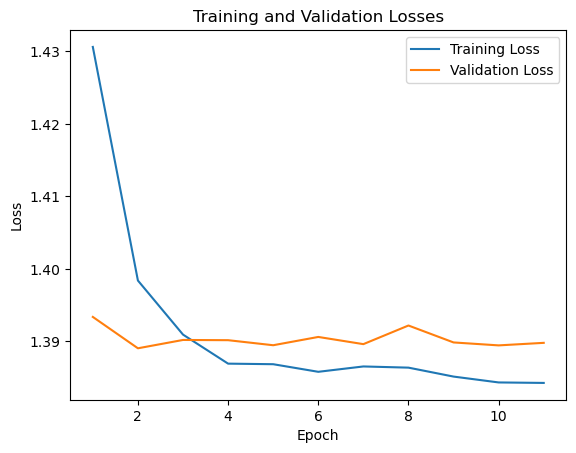

In [30]:
# Plot losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [34]:
writer.close()

In [85]:
def convert_to_rgb(spectrogram):
    # Normalize spectrogram to range [0, 255]
    spectrogram = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram)) * 255
    # Convert to PIL Image
    spectrogram_image = Image.fromarray(spectrogram.astype('uint8'), 'L')
    # Resize to 100x100
    resize_transform = transforms.Resize((100, 100))
    spectrogram_image = resize_transform(spectrogram_image)
    # Convert to RGB
    spectrogram_rgb = spectrogram_image.convert('RGB')
    return spectrogram_rgb

In [86]:
def predict_and_save(model, data, filename='submission.csv'):
    model.eval()
    with torch.no_grad():
        spectrogram = data[0]  # Extract the single example from the list
        spectrogram_rgb = convert_to_rgb(spectrogram)  # Convert to RGB
        spectrogram_rgb = np.array(spectrogram_rgb)  # Convert PIL Image to numpy array
        spectrogram_rgb = spectrogram_rgb.transpose(2, 0, 1)  # Transpose to (channels, height, width) format
        spectrogram_rgb = torch.from_numpy(spectrogram_rgb)  # Convert to torch tensor
        spectrogram_rgb = spectrogram_rgb.unsqueeze(0)  # Add batch dimension
        spectrogram_rgb = spectrogram_rgb.to(device, dtype=torch.float32)  # Convert to the correct data type

        # Perform inference on the preprocessed spectrogram
        outputs = model(spectrogram_rgb)
        probabilities = torch.sigmoid(outputs)  # Sigmoid to get probabilities
        normalized_probs = probabilities / probabilities.sum()  # Normalize probabilities using KL Divergence

    # Create a DataFrame with the normalized probabilities
    columns = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    df = pd.DataFrame([normalized_probs.cpu().numpy().squeeze()], columns=columns)

    # Add the eeg_id column based on the extracted label
    df.insert(0, 'eeg_id', test_labels['eeg_id'].iloc[0])

    # Get the current working directory
    current_dir = os.getcwd()
    # Combine the current directory and filename to get the full path
    full_path = os.path.join(current_dir, filename)
    
    # Reorder columns with 'eeg_id' as the first column
    df = df[['eeg_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
    
    # Save the DataFrame to a CSV file in the current directory
    df.to_csv(full_path, index=False)

In [35]:
# torch.save(model, os.getcwd() + "/saved_models/model_ini")
# model = torch.load(os.getcwd() + "/saved_models/model")

In [87]:
predict_and_save(model, test_spec, filename='submission.csv')
